In [4]:
import pandas as pd
from pathlib import Path
import pickle
from datetime import datetime, timedelta
import numpy as np

In [7]:
fourth_events_dirs = [Path('/home/hayden/park_center_data/4th/events')]
chestnut_events_dirs = [Path('/home/hayden/park_center_data/chestnut/usb/events'), Path('/home/hayden/park_center_data/chestnut/usb2/events')]

In [9]:
def get_moments(events_dirs):
    moments = []
    for events_dir in events_dirs:
        for events_subdir in events_dir.iterdir():
            moments_file = Path(events_subdir, 'moments.pickle')

            if moments_file.exists():
                with open(moments_file, 'rb') as f:
                    event_moments = pickle.load(f)
                for m in event_moments:
                    moments.append(m)
            else:
                print(f'No moments.pickle for {events_subdir}.')
    return moments

In [10]:
fourth_moments = get_moments(fourth_events_dirs)

No moments.pickle for /home/hayden/park_center_data/4th/events/1107.
No moments.pickle for /home/hayden/park_center_data/4th/events/92.
No moments.pickle for /home/hayden/park_center_data/4th/events/165.
No moments.pickle for /home/hayden/park_center_data/4th/events/93.


In [11]:
chestnut_moments = get_moments(chestnut_events_dirs)

No moments.pickle for /home/hayden/park_center_data/chestnut/usb/events/1326.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb/events/._.DS_Store.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb/events/.DS_Store.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb/events/0.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb/events/1299.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb2/events/1326.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb2/events/0.
No moments.pickle for /home/hayden/park_center_data/chestnut/usb2/events/1299.


In [12]:
print(fourth_moments[0])
print(chestnut_moments[0])

{'train_prediction_value': 0.12845877, 'img_path': '/mnt/usb/events/1373/images/0.jpg', 'signal_prediction_value': 0.01666848547756672, 'event_number': 1373, 'timestamp': '20200209_075059'}
{'event_number': 1373, 'timestamp': '20200214_225439', 'train_prediction_value': 0.97462726, 'img_path': '/mnt/usb/events/1373/images/0.jpg', 'signal_prediction_value': 6.9686002e-06}


In [14]:
def get_events(moments):
    events = {}
    for m in moments:
        event_number = m['event_number']
        timestamp = datetime.strptime(m['timestamp'], '%Y%m%d_%H%M%S')

        if event_number in events:
            if timestamp < events[event_number]['start_time']:
                events[event_number]['start_time'] = timestamp
            elif timestamp > events[event_number]['end_time']:
                events[event_number]['end_time'] = timestamp
        else:
            events[event_number] = {'start_time': datetime.max, 'end_time': datetime.min}
    
    return events

In [15]:
fourth_events = get_events(fourth_moments)

In [16]:
chestnut_events = get_events(chestnut_moments)

In [17]:
fourth_events_df = pd.DataFrame.from_dict(fourth_events, orient='index')
fourth_events_df.head()

,start_time,end_time
1373,2020-02-09 07:51:03,2020-02-09 08:20:57
1624,2020-02-18 14:30:13,2020-02-18 14:30:42
316,2019-12-14 02:24:09,2019-12-14 02:25:20
638,2019-12-19 04:36:42,2019-12-19 04:40:52
4270,2020-09-26 15:22:01,2020-09-26 15:35:49


In [18]:
chestnut_events_df = pd.DataFrame.from_dict(chestnut_events, orient='index')
chestnut_events_df.head()

,start_time,end_time
1373,2020-02-14 22:54:39,2020-02-14 22:54:56
1624,2020-02-26 02:49:18,2020-02-26 02:49:37
316,2020-02-01 17:24:52,2020-02-01 17:29:32
638,2020-02-04 05:17:57,2020-02-04 05:18:17
418,2020-02-02 20:45:03,2020-02-02 20:45:20


In [20]:
# Add duration col
fourth_events_df['duration'] = fourth_events_df['end_time'] - fourth_events_df['start_time']
chestnut_events_df['duration'] = chestnut_events_df['end_time'] - chestnut_events_df['start_time']
# Filter events =< 1 min in duration
fourth_events_df = fourth_events_df.loc[fourth_events_df['duration'] > timedelta(minutes=1)]
chestnut_events_df = chestnut_events_df.loc[chestnut_events_df['duration'] > timedelta(minutes=1)]
# Add date col
fourth_events_df['date'] = fourth_events_df.apply(lambda e: e['start_time'].date(), axis=1)
chestnut_events_df['date'] = chestnut_events_df.apply(lambda e: e['start_time'].date(), axis=1)
# Add month col
fourth_events_df['month'] = fourth_events_df.apply(lambda e: e['start_time'].month, axis=1)
chestnut_events_df['month'] = chestnut_events_df.apply(lambda e: e['start_time'].month, axis=1)
# Add day col
fourth_events_df['day'] = fourth_events_df.apply(lambda e: e['start_time'].day, axis=1)
chestnut_events_df['day'] = chestnut_events_df.apply(lambda e: e['start_time'].day, axis=1)
# Add hour col
fourth_events_df['hour'] = fourth_events_df.apply(lambda e: e['start_time'].hour, axis=1)
chestnut_events_df['hour'] = chestnut_events_df.apply(lambda e: e['start_time'].hour, axis=1)

In [21]:
print("# Fourth events: {}".format(len(fourth_events_df)))
print("# Chestnut events: {}".format(len(chestnut_events_df)))

# Fourth events: 3405
# Chestnut events: 2701


In [ ]:
def find_overlapping_events(events_a, events_b):
    overlapping_events = []
    total_events = len(events_a)
    count = 0
    for idx_a, event_a in events_a.iterrows():
        overlappers = [event_a]
        for idx_b, event_b in events_b.iterrows():
            if event_a["start_time"] < event_b["end_time"] and event_a["start_time"] > event_b["start_time"] \
            or event_a["end_time"] < event_b["end_time"] and event_a["end_time"] > event_b["start_time"]:
                overlappers.append(event_b)
        
        if len(overlappers) > 1:
            overlapping_events.append(overlappers)
        
        if count % 50 == 0:
            print("{}/{}".format(count, total_events), flush=True)
        count += 1
    return overlapping_events

In [ ]:
overlapping_events = find_overlapping_events(fourth_events_df, chestnut_events_df)

In [ ]:
print("# overlappers: {}".format(len(overlapping_events)))

In [15]:
# Average and standard deviation of event duration in each month
events_df['duration_int'] = events_df['duration'].values.astype(np.int64)
duration_means = events_df.groupby('month')['duration_int'].mean()
duration_stds = events_df.groupby('month')['duration_int'].std()
duration_means = pd.to_timedelta(duration_means)
duration_stds = pd.to_timedelta(duration_stds)
duration_maxes = events_df.groupby('month')['duration_int'].max()
duration_mins = events_df.groupby('month')['duration_int'].min()
duration_maxes = pd.to_timedelta(duration_maxes)
duration_mins = pd.to_timedelta(duration_mins)
# march_events_df = events_df[events_df['month'] == 3]
print('MEAN:\n', duration_means, '\n')
print('STD:\n', duration_stds, '\n')
print('MAX:\n', duration_maxes, '\n')
print('MIN:\n', duration_mins, '\n')

MEAN:
 month
1    00:07:30.470108
2    00:09:09.761229
3    00:09:49.353200
4    00:07:26.360784
5    00:07:42.934272
6    00:11:12.858064
7    00:13:43.321428
8    00:13:24.596226
9    00:09:38.195876
10   00:12:44.487272
11   00:15:17.934426
12   00:10:38.570743
Name: duration_int, dtype: timedelta64[ns] 

STD:
 month
1    00:10:36.727322
2    00:14:01.180093
3    00:13:30.009807
4    00:10:55.571713
5    00:10:16.572108
6    00:21:09.552352
7    00:21:10.238538
8    00:27:46.577607
9    00:12:00.055936
10   00:21:51.258200
11   00:23:56.410348
12   00:36:18.994865
Name: duration_int, dtype: timedelta64[ns] 

MAX:
 month
1    01:58:05
2    03:18:18
3    01:58:46
4    01:53:14
5    01:03:39
6    02:46:45
7    03:10:47
8    05:04:59
9    01:26:19
10   03:20:35
11   02:26:26
12   11:22:44
Name: duration_int, dtype: timedelta64[ns] 

MIN:
 month
1    00:01:06
2    00:01:02
3    00:01:03
4    00:01:03
5    00:01:02
6    00:01:01
7    00:01:02
8    00:01:09
9    00:01:05
10   00:01:02
11  

In [16]:
event_stats_df = pd.DataFrame({'mean': duration_means, 'std': duration_stds, 'max': duration_maxes, 'min': duration_mins})
event_stats_df.to_html('temp.html')

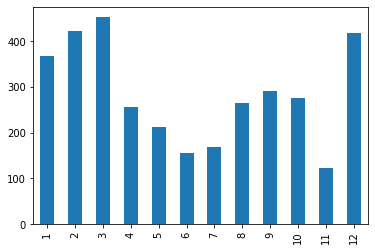

In [17]:
ax = events_df['month'].value_counts().sort_index().plot(kind='bar')
ax.figure.savefig('events_vs_month.jpg')

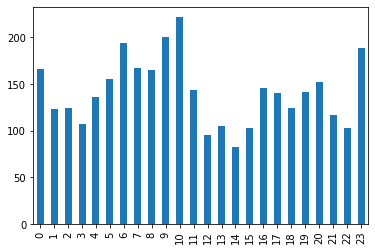

In [18]:
ax = events_df['hour'].value_counts().sort_index().plot(kind='bar')
ax.figure.savefig('events_vs_hour.jpg')

In [19]:
events_df.head()

,start_time,end_time,duration,date,month,day,hour,duration_int
1373,2020-02-09 07:51:03,2020-02-09 08:20:57,00:29:54,2020-02-09,2,9,7,1794000000000
316,2019-12-14 02:24:09,2019-12-14 02:25:20,00:01:11,2019-12-14,12,14,2,71000000000
638,2019-12-19 04:36:42,2019-12-19 04:40:52,00:04:10,2019-12-19,12,19,4,250000000000
4270,2020-09-26 15:22:01,2020-09-26 15:35:49,00:13:48,2020-09-26,9,26,15,828000000000
3988,2020-09-01 20:22:46,2020-09-01 20:28:47,00:06:01,2020-09-01,9,1,20,361000000000


In [18]:
# events_df.to_excel("/home/hayden/park_center_data/4th_events.xlsx")
events_df.to_pickle("/home/hayden/park_center_data/4th_events.pickle") 

In [ ]:
# - Double blockage events are when there's significant overlap between chestnut and fourth time intervals.
# - Blocking chestnut -- can get out of that. Blocking fourth -- hard to get out.
# - 